In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from sklearn.linear_model import LogisticRegression
mpl.rcParams['figure.dpi'] = 200

In [2]:
df = pd.read_csv('data/df_clean.csv')

array([[<AxesSubplot:title={'center':'LIMIT_BAL'}>,
        <AxesSubplot:title={'center':'AGE'}>]], dtype=object)

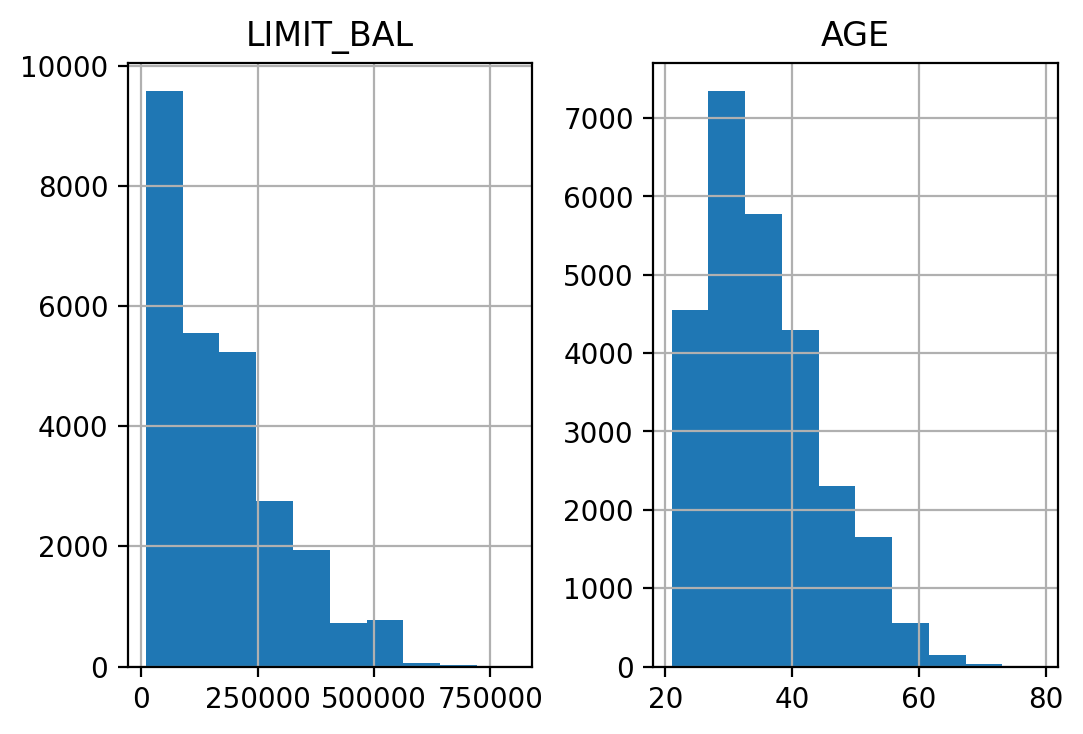

In [3]:
df[['LIMIT_BAL', 'AGE']].hist()

In [4]:
df[['LIMIT_BAL', 'AGE']].describe()

,LIMIT_BAL,AGE
count,26664.000000,26664.000000
mean,167919.054905,35.505213
std,129839.453081,9.227442
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,800000.000000,79.000000


In [5]:
df['EDUCATION'].value_counts()

2    12458
1     9412
3     4380
5      245
4      115
6       43
0       11
Name: EDUCATION, dtype: int64

We see undocumented education levels 0, 5, and 6, as the data dictionary describes only Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

In [6]:
# since 0, 5, 6 are a small part, roll them up into 4 (others)
df['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)
df['EDUCATION'].value_counts()

2    12458
1     9412
3     4380
4      414
Name: EDUCATION, dtype: int64

In [7]:
df['MARRIAGE'].value_counts()
# 0 is not documented in the data dictionary and we lump it with 3 (others)
df['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)
df['MARRIAGE'].value_counts()

2    14158
1    12172
3      334
Name: MARRIAGE, dtype: int64

Text(0.5, 0, 'Education')

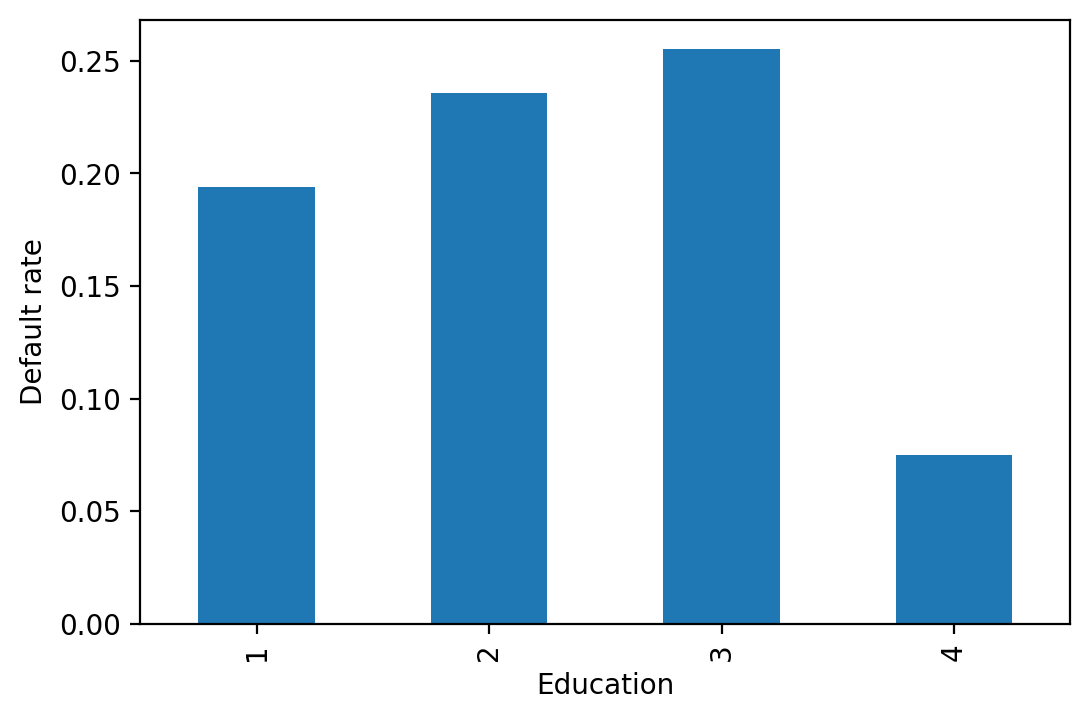

In [8]:
# exploring EDUCATION feature
df.groupby('EDUCATION').agg({'default payment next month':'mean'}).plot.bar(legend=False)
plt.ylabel('Default rate')
plt.xlabel('Education')

It looks like a straight-line fit would probably not be the best description of the data here. In case a feature has a non-linear effect like this, it may be better to use a more complex algorithm such as a decision tree or random forest. Or, if a simpler and more interpretable linear model such as logistic regression is desired, we could avoid an ordinal encoding and use a different way of encoding categorical variables. A popular way of doing this is called one-hot encoding (OHE).

## OHE

In [9]:
# create category mappings
cat_mapping = {1: "graduate school",2: "university",
               3: "high school",4: "others"}
# create new column by mapping categories to EDUCATIOn
df['EDUCATION_CAT'] = df['EDUCATION'].map(cat_mapping)

df[['EDUCATION', 'EDUCATION_CAT']].head(10)

,EDUCATION,EDUCATION_CAT
0,2,university
1,2,university
2,2,university
3,2,university
4,2,university
5,1,graduate school
6,1,graduate school
7,2,university
8,3,high school
9,3,high school


In [10]:
edu_ohe = pd.get_dummies(df['EDUCATION_CAT'])
edu_ohe.head(10)

,graduate school,high school,others,university
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
5,1,0,0,0
6,1,0,0,0
7,0,0,0,1
8,0,1,0,0
9,0,1,0,0


In [11]:
df_ohe = pd.concat([df, edu_ohe], axis=1)
df_ohe[['EDUCATION_CAT', 'graduate school','high school', 'university', 'others']].head(10)

,EDUCATION_CAT,graduate school,high school,university,others
0,university,0,0,1,0
1,university,0,0,1,0
2,university,0,0,1,0
3,university,0,0,1,0
4,university,0,0,1,0
5,graduate school,1,0,0,0
6,graduate school,1,0,0,0
7,university,0,0,1,0
8,high school,0,1,0,0
9,high school,0,1,0,0


In [12]:
# exploring financial features
pay_feats = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df[pay_feats].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,-0.017777,-0.133363,-0.167679,-0.225023,-0.269764,-0.293579
std,1.126769,1.198640,1.199165,1.167897,1.131735,1.150229
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


array([[<AxesSubplot:title={'center':'PAY_1'}>,
        <AxesSubplot:title={'center':'PAY_2'}>,
        <AxesSubplot:title={'center':'PAY_3'}>],
       [<AxesSubplot:title={'center':'PAY_4'}>,
        <AxesSubplot:title={'center':'PAY_5'}>,
        <AxesSubplot:title={'center':'PAY_6'}>]], dtype=object)

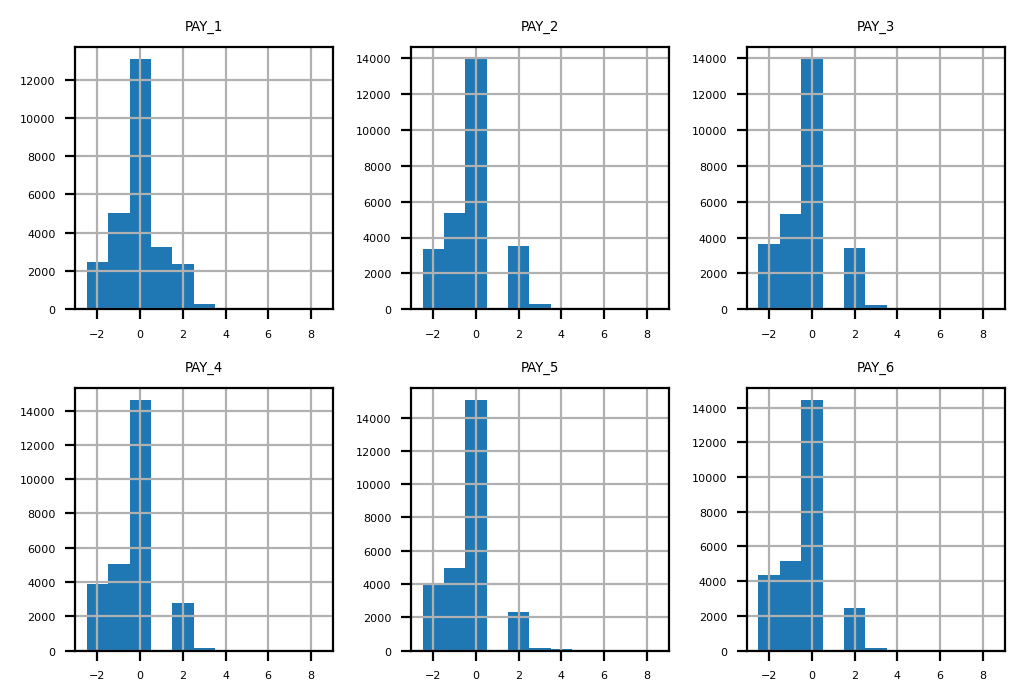

In [13]:
# visualizing the pay features
pay_bins = np.array(range(-2,10)) - 0.5
# reduce font size to view range of values
mpl.rcParams['font.size'] = 4
df[pay_feats].hist(bins=pay_bins, layout=(2,3))

There seems to be an issue with the PAYs. Reviewing the values between July (PAY_3) and August (PAY_2). In July, there are very few accounts that had a 1-month payment delay; this bar is not really visible in the histogram. However, in August, there are suddenly thousands of accounts with a 2-month payment delay. This does not make sense as the number of accounts with a 2-month delay in a given month should be less than or equal to the number of accounts with a 1-month delay in the previous month.

In [14]:
df.loc[df['PAY_2']==2, ['PAY_2', 'PAY_3']].head()

,PAY_2,PAY_3
0,2,-1
1,2,0
13,2,2
15,2,0
47,2,2


Only the most recent month of our payment status data is correct. This means that, of all the payment status features, only PAY_1 is representative of future data, those that will be used to make predictions with the model we develop.

In [15]:
# exploring bill amount features
bill_feats = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

In [16]:
df[bill_feats].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,51405.730723,49300.001500,47026.340047,43338.894539,40338.136701,38889.872337
std,73633.687106,70934.549534,68705.359524,64275.250740,60705.944083,59432.541657
min,-165580.000000,-69777.000000,-157264.000000,-170000.000000,-81334.000000,-339603.000000
25%,3580.000000,2999.750000,2627.250000,2341.750000,1745.000000,1256.000000
50%,22361.000000,21150.000000,20079.500000,19037.000000,18066.000000,17005.000000
75%,67649.750000,64395.500000,60360.000000,54727.500000,50290.500000,49253.750000
max,746814.000000,671563.000000,855086.000000,706864.000000,823540.000000,699944.000000


array([[<AxesSubplot:title={'center':'BILL_AMT1'}>,
        <AxesSubplot:title={'center':'BILL_AMT2'}>,
        <AxesSubplot:title={'center':'BILL_AMT3'}>],
       [<AxesSubplot:title={'center':'BILL_AMT4'}>,
        <AxesSubplot:title={'center':'BILL_AMT5'}>,
        <AxesSubplot:title={'center':'BILL_AMT6'}>]], dtype=object)

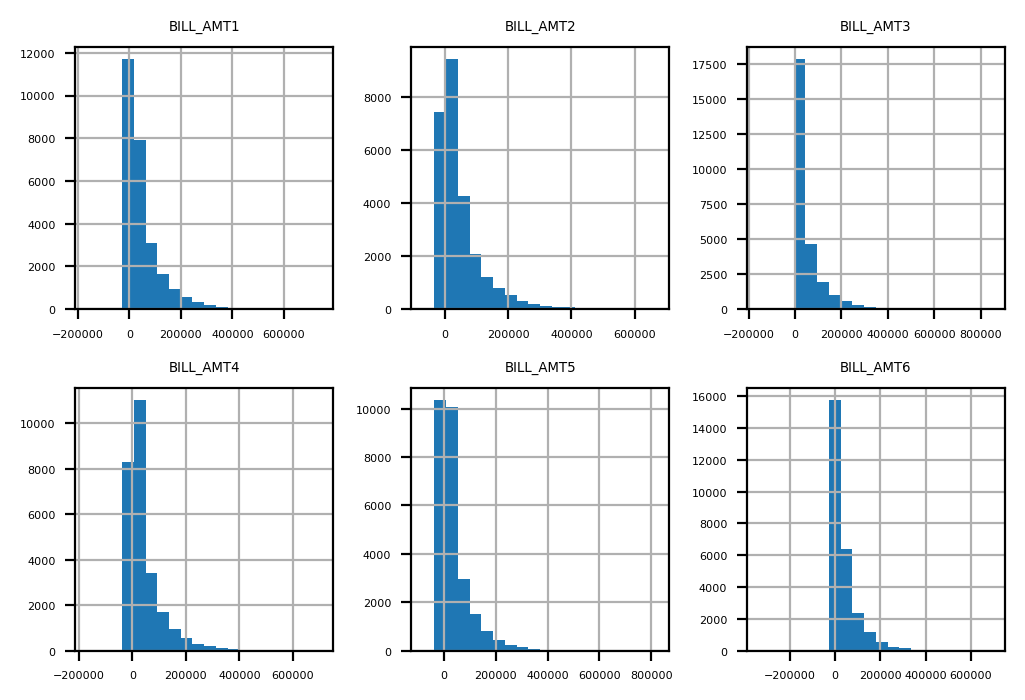

In [17]:
df[bill_feats].hist(bins=20, layout=(2,3))

In [18]:
pay_amt_feats = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df[pay_amt_feats].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,26664.000000,2.666400e+04,26664.000000,26664.000000,26664.000000,26664.000000
mean,5704.085771,5.881110e+03,5259.514964,4887.048717,4843.729973,5257.843047
std,16699.398632,2.121431e+04,17265.439561,15956.349371,15311.721795,17635.468185
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.020000e+02,390.000000,294.750000,242.750000,111.000000
50%,2114.500000,2.007000e+03,1822.000000,1500.000000,1500.000000,1500.000000
75%,5027.000000,5.000000e+03,4556.250000,4050.500000,4082.750000,4015.000000
max,873552.000000,1.227082e+06,889043.000000,621000.000000,426529.000000,528666.000000


array([[<AxesSubplot:title={'center':'PAY_AMT1'}>,
        <AxesSubplot:title={'center':'PAY_AMT2'}>,
        <AxesSubplot:title={'center':'PAY_AMT3'}>],
       [<AxesSubplot:title={'center':'PAY_AMT4'}>,
        <AxesSubplot:title={'center':'PAY_AMT5'}>,
        <AxesSubplot:title={'center':'PAY_AMT6'}>]], dtype=object)

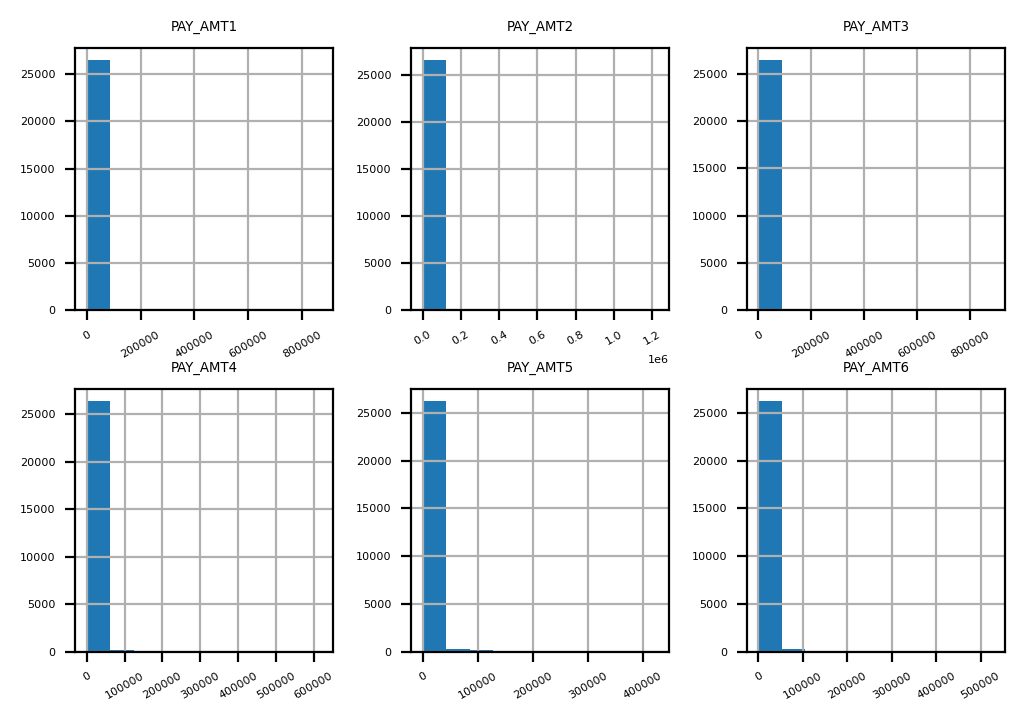

In [19]:
df[pay_amt_feats].hist(layout=(2,3), xrot=30)

Most records of payment amounts are 0, which makes sense. However, this visualization is not helpful.

array([[<AxesSubplot:title={'center':'PAY_AMT1'}>,
        <AxesSubplot:title={'center':'PAY_AMT2'}>,
        <AxesSubplot:title={'center':'PAY_AMT3'}>],
       [<AxesSubplot:title={'center':'PAY_AMT4'}>,
        <AxesSubplot:title={'center':'PAY_AMT5'}>,
        <AxesSubplot:title={'center':'PAY_AMT6'}>]], dtype=object)

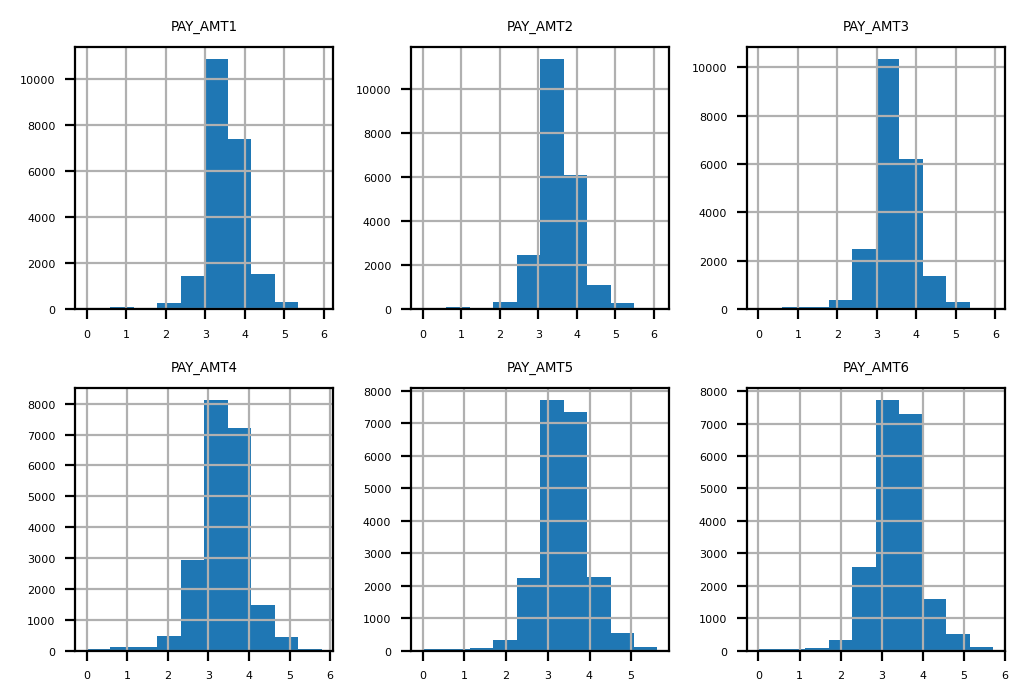

In [20]:
pay_zero_mask = df[pay_amt_feats] == 0
# apply log transform to adjust for different scales
df[pay_amt_feats][~pay_zero_mask].apply(np.log10).hist(layout=(2,3))

In [21]:
df.to_csv('data/df_clean_2.csv', index=False)